Analysis submission script directory is `/g/data/x77/cy8964/Analysis/cross_slope_transports`

In [3]:
import cosima_cookbook as cc
import numpy as np
import netCDF4 as nc
import xarray as xr
from gsw import SA_from_SP, p_from_z, sigma1
import sys,os
from pathlib import Path

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import climtas.nci


In [4]:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
master_session = cc.database.create_session(session_name)
control = '01deg_jra55v13_ryf9091_DSW'

session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)


basal_gade_woa = 'accessom2-GPC023'

icb_gade_woa = 'accessom2-GPC026'


In [5]:
session = basal_melt_session
expt = basal_gade_woa

dyt = cc.querying.getvar(expt, 'dyt',session, n=1, ncfile = 'ocean_grid.nc')

In [14]:
salt = cc.querying.getvar(expt,'salt',session,ncfile='%daily%')
salt

VariableNotFoundError: No files were found containing 'salt' in the '01deg_jra55v13_ryf9091_DSW' experiment

In [6]:
vhrho = cc.querying.getvar(expt,'vhrho_nt',session,ncfile='%daily%')

uhrho = cc.querying.getvar(expt,'uhrho_et',session,ncfile='%daily%')

potrho0 = cc.querying.getvar(expt,'pot_rho_0',session,ncfile='%daily%')
potrho0

<xarray.DataArray 'pot_rho_0' (time: 3650, st_ocean: 75, yt_ocean: 2700,
                               xt_ocean: 3600)>
dask.array<concatenate, shape=(3650, 75, 2700, 3600), dtype=float32, chunksize=(1, 19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 1900-01-01 12:00:00 ... 1909-12-31 12:00:00
Attributes:
    long_name:      potential density referenced to 0 dbar
    units:          kg/m^3
    valid_range:    [-1.e+01  1.e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_potential_density
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/a...

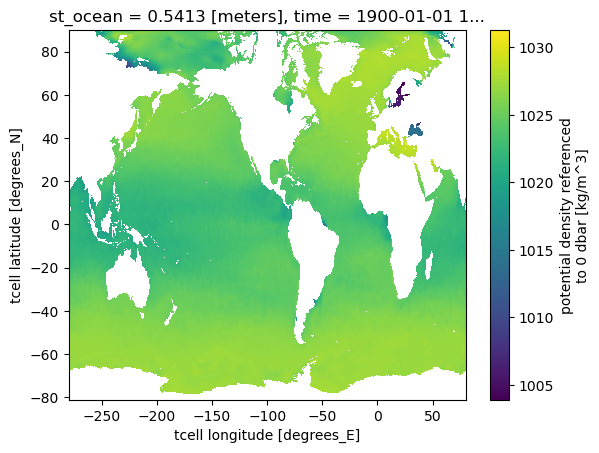

In [8]:
potrho0.isel(time = 0).isel(st_ocean = 0).plot()

In [9]:
potrho0.isel(time = 0).sel(yt_ocean = slice(-90,-59)).min().values


array(1025.1998, dtype=float32)

In [13]:
potrho0.isel(time = 0).sel(yt_ocean = slice(-90,-59)).max().values


array(1028.1425, dtype=float32)

In [14]:
month = '01'
year = '1900'

In [15]:
# # # Compute daily transports along contour and save


# import cosima_cookbook as cc
# import numpy as np
# import netCDF4 as nc
# import xarray as xr
# from gsw import SA_from_SP, p_from_z, sigma1
# import sys,os
# from pathlib import Path

# import logging
# logging.captureWarnings(True)
# logging.getLogger('py.warnings').setLevel(logging.ERROR)

# from dask.distributed import Client
# import climtas.nci

# if __name__ == '__main__':

# Start a dask cluster with multiple cores
climtas.nci.GadiClient()
# dask_dir = '/scratch/x77/cy8964/dask_dump/dask_dump_'+str(sys.argv[2])+'_'+str(int(sys.argv[1]))+'/'
# Path(dask_dir).mkdir(parents=True, exist_ok=True)
# client = Client(local_directory=dask_dir)
client = Client()
session = cc.database.create_session('/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db')
#session = cc.database.create_session('/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db')
#session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [16]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33519/status,
Dashboard: /proxy/33519/status,Workers: 7
Total threads: 28,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39277,Workers: 7
Dashboard: /proxy/33519/status,Total threads: 28
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:43323,Total threads: 4
Dashboard: /proxy/33081/status,Memory: 35.71 GiB
Nanny: tcp://127.0.0.1:34971,


In [17]:
expt = 'accessom2-GPC023'
#expt = '01deg_jra55v13_ryf9091_DSW'
#expt = '01deg_jra55v13_ryf9091_rerun_for_easterlies'
#expt = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'
###############################
#### get run count argument that was passed to python script ####

# month = str(int(sys.argv[1]))
# month = month.zfill(2)

# year = str(sys.argv[2])

first_year = year
last_year = year

start_time=first_year+'-'+month
end_time=last_year+'-'+month

# reference density value:
rho_0 = 1035.0
lat_range = slice(-90,-59)

###############################
# ### Open grid cell width data for domain

## some grid data is required, a little complicated because these variables don't behave well with some 
dyt = cc.querying.getvar(expt, 'dyt',session, n=1, ncfile = 'ocean_grid.nc')
dxu = cc.querying.getvar(expt, 'dxu',session, n=1, ncfile = 'ocean_grid.nc')

# select latitude range:
dxu = dxu.sel(yu_ocean=lat_range)
dyt = dyt.sel(yt_ocean=lat_range)

###############################
# ### Open contour data

isobath_depth = 1000
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(expt,'xu_ocean',session,n=1)

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vhrho, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for uhrho, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

# ### Stack contour data into 1D

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
# don't need the multi-index anymore, replace with contour count
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

###############################
# ### Open uhrho, vhrho from daily data

# Note vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell.
vhrho = cc.querying.getvar(expt,'vhrho_nt',session,ncfile='%daily%')
uhrho = cc.querying.getvar(expt,'uhrho_et',session,ncfile='%daily%')

# the coords on regional variables might be wacky, in which case need to do:
vhrho = vhrho.rename({'yt_ocean_sub01':'yt_ocean', 'xt_ocean_sub01':'xt_ocean'})
uhrho = uhrho.rename({'yt_ocean_sub01':'yt_ocean', 'xt_ocean_sub01':'xt_ocean'})
# if meridional length is too long, cut to match:
vhrho = vhrho[:,:,:len(yt_ocean),:]
uhrho = uhrho[:,:,:len(yt_ocean),:]
vhrho.coords['yt_ocean'] = yt_ocean
uhrho.coords['yt_ocean'] = yt_ocean

# select latitude range and this month:
vhrho = vhrho.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))
uhrho = uhrho.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))

# Note that vhrho is defined as the transport across the northern edge of a tracer cell so its coordinates 
#       should be (yu_ocean, xt_ocean).
#  uhrho is defined as the transport across the eastern edge of a tracer cell so its coordinates should 
#       be (yt_ocean, xu_ocean).
#  However we will keep the actual name as simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation and sorting possible.
yt_ocean = dyt.yt_ocean.values
yu_ocean = dxu.yu_ocean.values
xu_ocean = dxu.xu_ocean.values
xt_ocean = dyt.xt_ocean.values
vhrho.coords['yt_ocean'] = yu_ocean
uhrho.coords['xt_ocean'] = xu_ocean
vhrho = vhrho.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'})
uhrho = uhrho.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'})

# ### Convert to transports 

# First we also need to change coords on dxu, dyt, so we can multiply the transports:
dyt = dyt.reset_coords().dyt # remove geolon_t/geolat_t coordinates
dxu = dxu.reset_coords().dxu # remove geolon_t/geolat_t coordinates
dxu.coords['xu_ocean'] = xt_ocean
dxu = dxu.rename({'yu_ocean':'y_ocean', 'xu_ocean':'x_ocean'}) 
dyt.coords['xt_ocean'] = xu_ocean
dyt = dyt.rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'})

# convert to transports and multiply by contour masks:
vhrho = vhrho*dxu*mask_y_transport/rho_0
uhrho = uhrho*dyt*mask_x_transport/rho_0

###############################
# ### Extract transport values along contour:

## initiate a empty dataarray
vol_trans_across_contour = xr.DataArray(np.zeros((len(uhrho.time),len(uhrho.st_ocean),len(contour_index_array))),
                                        coords = [uhrho.time,uhrho.st_ocean, contour_index_array],
                                        dims = ['time','st_ocean', 'contour_index'],
                                        name = 'vol_trans_across_contour')

# stack transports into 1d and drop any points not on contour:
x_transport_1d = uhrho.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop = True)
y_transport_1d = vhrho.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim = 'contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = vol_trans_across_contour.load()

del uhrho, vhrho, x_transport_1d, y_transport_1d
###############################
# ### Extract potrho0 along contour:

In [18]:
potrho0 = cc.querying.getvar(expt,'pot_rho_0',session,ncfile='%daily%')

# # the coords on regional variables might be wacky, in which case need to do:
# potrho0 = potrho0.rename({'yt_ocean_sub01':'yt_ocean', 'xt_ocean_sub01':'xt_ocean'})
# if meridional length is too long, cut to match:
potrho0 = potrho0[:,:,:len(yt_ocean),:]
potrho0.coords['yt_ocean'] = yt_ocean

potrho0 = potrho0.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))

# interpolate to correct grid:
potrho0 = potrho0.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'}) 
potrho0_w = potrho0.copy()
potrho0_w.coords['x_ocean'] = xu_ocean
potrho0_e = potrho0.roll(x_ocean=-1)
potrho0_e.coords['x_ocean'] = xu_ocean
# potrho0_xgrid will be on the uhrho grid:
potrho0_xgrid = (potrho0_e + potrho0_w)/2

potrho0_s = potrho0.copy()
potrho0_s.coords['y_ocean'] = yu_ocean
potrho0_n = potrho0.roll(y_ocean=-1)
potrho0_n.coords['y_ocean'] = yu_ocean
# potrho0_ygrid will be on the vhrho grid:
potrho0_ygrid = (potrho0_s + potrho0_n)/2

# stack transports into 1d and drop any points not on contour:
potrho0_xgrid = potrho0_xgrid.where(mask_x_transport_numbered>0)
potrho0_ygrid = potrho0_ygrid.where(mask_y_transport_numbered>0)
x_potrho0_1d = potrho0_xgrid.stack(contour_index = ['y_ocean', 'x_ocean'])
y_potrho0_1d = potrho0_ygrid.stack(contour_index = ['y_ocean', 'x_ocean'])
x_potrho0_1d = x_potrho0_1d.where(mask_x_numbered_1d>0,drop=True)
y_potrho0_1d = y_potrho0_1d.where(mask_y_numbered_1d>0,drop=True)

# combine all points on contour:
potrho0_along_contour = xr.concat((x_potrho0_1d, y_potrho0_1d), dim = 'contour_index')
potrho0_along_contour = potrho0_along_contour.sortby(contour_ordering)
potrho0_along_contour.coords['contour_index'] = contour_index_array
potrho0_along_contour = potrho0_along_contour.load()

###############################
# ### Bin into density:
## define isopycnal bins   
#isopycnal_bins_sigma0 = np.append(np.append(np.append(1,np.arange(27,32,.1)),np.arange(32,32.8,.01)),40)
isopycnal_bins_sigma0 = np.append(np.append(np.append(1000,np.arange(1024,1027.5,.1)),np.arange(1027.5,1028.4,.01)),1040)

## intialise empty transport along contour in density bins array
vol_trans_across_contour_binned = xr.DataArray(np.zeros((len(isopycnal_bins_sigma0),len(contour_ordering))), 
                                                   coords = [isopycnal_bins_sigma0, contour_index_array], 
                                                   dims = ['isopycnal_bins', 'contour_index'], 
                                                   name = 'vol_trans_across_contour_binned')

# loop through density bins:
for i in range(len(isopycnal_bins_sigma0)-1):
    print(i)
    bin_mask = potrho0_along_contour.where(potrho0_along_contour<=isopycnal_bins_sigma0[i+1]).where(potrho0_along_contour>isopycnal_bins_sigma0[i])*0+1
    bin_fractions = (isopycnal_bins_sigma0[i+1]-potrho0_along_contour * bin_mask)/(isopycnal_bins_sigma0[i+1]-isopycnal_bins_sigma0[i])
    ## transport
    transport_across_contour_in_sigmalower_bin = (vol_trans_across_contour * bin_mask * bin_fractions).sum(dim = 'st_ocean')
    vol_trans_across_contour_binned[i,:] += transport_across_contour_in_sigmalower_bin.fillna(0).mean('time')
    del transport_across_contour_in_sigmalower_bin
    transport_across_contour_in_sigmaupper_bin = (vol_trans_across_contour * bin_mask * (1-bin_fractions)).sum(dim = 'st_ocean')
    vol_trans_across_contour_binned[i+1,:] += transport_across_contour_in_sigmaupper_bin.fillna(0).mean('time')
    del bin_mask, bin_fractions, transport_across_contour_in_sigmaupper_bin

days_in_month = len(vol_trans_across_contour.time)

###############################

### Save:
save_dir = '/g/data/x77/cy8964/Post_Process/access-om2/'+expt+'/Antarctic_cross_slope/'
# make sure dir exists:
if not os.path.lexists(save_dir):
    os.mkdir(save_dir)
ds_vol_trans_across_contour = xr.Dataset({'vol_trans_across_contour_binned': vol_trans_across_contour_binned, 'ndays': days_in_month})
ds_vol_trans_across_contour.to_netcdf(save_dir+'vol_trans_across_contour_'+year+'_'+month+'.nc')

2023-08-14 11:35:40,748 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-08-14 11:36:00,806 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-08-14 11:36:08,233 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-08-14 11:36:14,465 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-08-14 11:36:16,722 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-08-14 11:36:27,434 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-08-14 11:36:28,433 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-08-14 11:36:31,436 - distributed.utils_perf - WARNING - full garbage collections took

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


(1028.3, 1025.0)

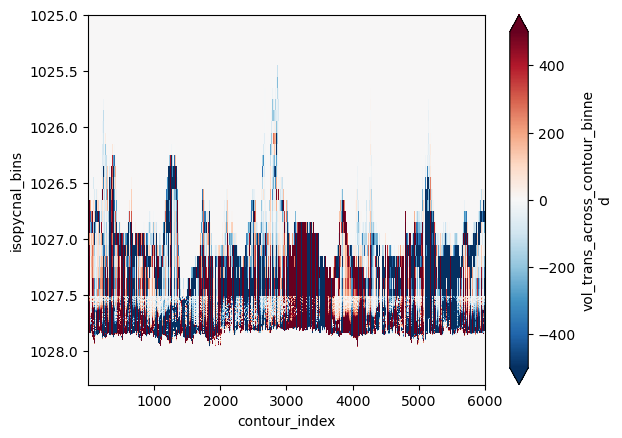

In [29]:
import matplotlib.pyplot as plt
vol_trans_across_contour_binned.isel(isopycnal_bins = np.arange(126)).plot(vmax = 500)
plt.ylim(1028.3,1025)

In [ ]:
# # Compute daily transports along contour and save


import cosima_cookbook as cc
import numpy as np
import netCDF4 as nc
import xarray as xr
from gsw import SA_from_SP, p_from_z, sigma1
import sys,os
from pathlib import Path

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import climtas.nci

if __name__ == '__main__':

	# Start a dask cluster with multiple cores
	climtas.nci.GadiClient()
	#dask_dir = '/scratch/x77/cy8964/dask_dump/dask_dump_'+str(sys.argv[2])+'_'+str(int(sys.argv[1]))+'/'
	#Path(dask_dir).mkdir(parents=True, exist_ok=True)
	#client = Client(local_directory=dask_dir)

	session = cc.database.create_session('/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db')
	#session = cc.database.create_session('/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db')
	#session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
	expt = 'accessom2-GPC023'
	#expt = '01deg_jra55v13_ryf9091_DSW'
	###############################
	#### get run count argument that was passed to python script ####
	
	month = str(int(sys.argv[1]))
	month = month.zfill(2)

	year = str(sys.argv[2])

	first_year = year
	last_year = year

	start_time=first_year+'-'+month
	end_time=last_year+'-'+month

	# reference density value:
	rho_0 = 1035.0
	lat_range = slice(-90,-59)
	
	###############################
	# ### Open grid cell width data for domain

	## some grid data is required, a little complicated because these variables don't behave well with some 
	dyt = cc.querying.getvar(expt, 'dyt',session, n=1, ncfile = 'ocean_grid.nc')
	dxu = cc.querying.getvar(expt, 'dxu',session, n=1, ncfile = 'ocean_grid.nc')

	# select latitude range:
	dxu = dxu.sel(yu_ocean=lat_range)
	dyt = dyt.sel(yt_ocean=lat_range)

	###############################
	# ### Open contour data

	isobath_depth = 1000
	outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
	data = np.load(outfile)
	mask_y_transport = data['mask_y_transport']
	mask_x_transport = data['mask_x_transport']
	mask_y_transport_numbered = data['mask_y_transport_numbered']
	mask_x_transport_numbered = data['mask_x_transport_numbered']

	yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
	yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
	yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
	yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
	xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
	xu_ocean = cc.querying.getvar(expt,'xu_ocean',session,n=1)

	# Convert contour masks to data arrays, so we can multiply them later.
	# We need to ensure the lat lon coordinates correspond to the actual data location:
	#       The y masks are used for vhrho, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
	#       The x masks are used for uhrho, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
	#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
	#       to make concatenation of transports in both direction and sorting possible.

	mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
	mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
	mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
	mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

	# ### Stack contour data into 1D

	# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
	#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
	#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
	#   but we dont double up with numerous counts for one lat/lon point.

	# stack contour data into 1d:
	mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
	mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
	mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
	mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
	contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
	contour_ordering = contour_ordering.sortby(contour_ordering)
	contour_index_array = np.arange(1,len(contour_ordering)+1)
	
	# get lat and lon along contour, useful for plotting later:
	lat_along_contour = contour_ordering.y_ocean
	lon_along_contour = contour_ordering.x_ocean
	# don't need the multi-index anymore, replace with contour count
	lat_along_contour.coords['contour_index'] = contour_index_array
	lon_along_contour.coords['contour_index'] = contour_index_array

	###############################
	# ### Open uhrho, vhrho from daily data

	# Note vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell.
	vhrho = cc.querying.getvar(expt,'vhrho_nt',session,ncfile='%daily%')
	uhrho = cc.querying.getvar(expt,'uhrho_et',session,ncfile='%daily%')

	# the coords on regional variables might be wacky, in which case need to do:
	vhrho = vhrho.rename({'yt_ocean_sub01':'yt_ocean', 'xt_ocean_sub01':'xt_ocean'})
	uhrho = uhrho.rename({'yt_ocean_sub01':'yt_ocean', 'xt_ocean_sub01':'xt_ocean'})
	# if meridional length is too long, cut to match:
	vhrho = vhrho[:,:,:len(yt_ocean),:]
	uhrho = uhrho[:,:,:len(yt_ocean),:]
	vhrho.coords['yt_ocean'] = yt_ocean
	uhrho.coords['yt_ocean'] = yt_ocean

	# select latitude range and this month:
	vhrho = vhrho.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))
	uhrho = uhrho.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))

	# Note that vhrho is defined as the transport across the northern edge of a tracer cell so its coordinates 
	#       should be (yu_ocean, xt_ocean).
	#  uhrho is defined as the transport across the eastern edge of a tracer cell so its coordinates should 
	#       be (yt_ocean, xu_ocean).
	#  However we will keep the actual name as simply y_ocean/x_ocean irrespective of the variable
	#       to make concatenation and sorting possible.
	yt_ocean = dyt.yt_ocean.values
	yu_ocean = dxu.yu_ocean.values
	xu_ocean = dxu.xu_ocean.values
	xt_ocean = dyt.xt_ocean.values
	vhrho.coords['yt_ocean'] = yu_ocean
	uhrho.coords['xt_ocean'] = xu_ocean
	vhrho = vhrho.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'})
	uhrho = uhrho.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'})

	# ### Convert to transports 

	# First we also need to change coords on dxu, dyt, so we can multiply the transports:
	dyt = dyt.reset_coords().dyt # remove geolon_t/geolat_t coordinates
	dxu = dxu.reset_coords().dxu # remove geolon_t/geolat_t coordinates
	dxu.coords['xu_ocean'] = xt_ocean
	dxu = dxu.rename({'yu_ocean':'y_ocean', 'xu_ocean':'x_ocean'}) 
	dyt.coords['xt_ocean'] = xu_ocean
	dyt = dyt.rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'})

	# convert to transports and multiply by contour masks:
	vhrho = vhrho*dxu*mask_y_transport/rho_0
	uhrho = uhrho*dyt*mask_x_transport/rho_0
	
	###############################
	# ### Extract transport values along contour:

	## initiate a empty dataarray
	vol_trans_across_contour = xr.DataArray(np.zeros((len(uhrho.time),len(uhrho.st_ocean),len(contour_index_array))),
											coords = [uhrho.time,uhrho.st_ocean, contour_index_array],
											dims = ['time','st_ocean', 'contour_index'],
											name = 'vol_trans_across_contour')

	# stack transports into 1d and drop any points not on contour:
	x_transport_1d = uhrho.stack(contour_index = ['y_ocean', 'x_ocean'])
	x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop = True)
	y_transport_1d = vhrho.stack(contour_index = ['y_ocean', 'x_ocean'])
	y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop = True)

	# combine all points on contour:
	vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim = 'contour_index')
	vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
	vol_trans_across_contour.coords['contour_index'] = contour_index_array
	vol_trans_across_contour = vol_trans_across_contour.load()

	del uhrho, vhrho, x_transport_1d, y_transport_1d

	###############################
	# ### Extract potrho0 along contour:
	potrho0 = cc.querying.getvar(expt,'pot_rho_0',session,ncfile='%daily%')
	
	# # the coords on regional variables might be wacky, in which case need to do:
	# potrho0 = potrho0.rename({'yt_ocean_sub01':'yt_ocean', 'xt_ocean_sub01':'xt_ocean'})
	# if meridional length is too long, cut to match:
	potrho0 = potrho0[:,:,:len(yt_ocean),:]
	potrho0.coords['yt_ocean'] = yt_ocean
	
	potrho0 = potrho0.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))
	
	# interpolate to correct grid:
	potrho0 = potrho0.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'}) 
	potrho0_w = potrho0.copy()
	potrho0_w.coords['x_ocean'] = xu_ocean
	potrho0_e = potrho0.roll(x_ocean=-1)
	potrho0_e.coords['x_ocean'] = xu_ocean
	# potrho0_xgrid will be on the uhrho grid:
	potrho0_xgrid = (potrho0_e + potrho0_w)/2
	
	potrho0_s = potrho0.copy()
	potrho0_s.coords['y_ocean'] = yu_ocean
	potrho0_n = potrho0.roll(y_ocean=-1)
	potrho0_n.coords['y_ocean'] = yu_ocean
	# potrho0_ygrid will be on the vhrho grid:
	potrho0_ygrid = (potrho0_s + potrho0_n)/2
	
	# stack transports into 1d and drop any points not on contour:
	potrho0_xgrid = potrho0_xgrid.where(mask_x_transport_numbered>0)
	potrho0_ygrid = potrho0_ygrid.where(mask_y_transport_numbered>0)
	x_potrho0_1d = potrho0_xgrid.stack(contour_index = ['y_ocean', 'x_ocean'])
	y_potrho0_1d = potrho0_ygrid.stack(contour_index = ['y_ocean', 'x_ocean'])
	x_potrho0_1d = x_potrho0_1d.where(mask_x_numbered_1d>0,drop=True)
	y_potrho0_1d = y_potrho0_1d.where(mask_y_numbered_1d>0,drop=True)
	
	# combine all points on contour:
	potrho0_along_contour = xr.concat((x_potrho0_1d, y_potrho0_1d), dim = 'contour_index')
	potrho0_along_contour = potrho0_along_contour.sortby(contour_ordering)
	potrho0_along_contour.coords['contour_index'] = contour_index_array
	potrho0_along_contour = potrho0_along_contour.load()
	
	###############################
	# ### Bin into density:
	## define isopycnal bins   
	isopycnal_bins_sigma0 = np.append(np.append(np.append(1000,np.arange(1024,1027.5,.1)),np.arange(1027.5,1028.4,.01)),1040)
	
	## intialise empty transport along contour in density bins array
	vol_trans_across_contour_binned = xr.DataArray(np.zeros((len(isopycnal_bins_sigma0),len(contour_ordering))), 
	                                                   coords = [isopycnal_bins_sigma0, contour_index_array], 
	                                                   dims = ['isopycnal_bins', 'contour_index'], 
	                                                   name = 'vol_trans_across_contour_binned')
	
	# loop through density bins:
	for i in range(len(isopycnal_bins_sigma0)-1):
	    print(i)
	    bin_mask = potrho0_along_contour.where(potrho0_along_contour<=isopycnal_bins_sigma0[i+1]).where(potrho0_along_contour>isopycnal_bins_sigma0[i])*0+1
	    bin_fractions = (isopycnal_bins_sigma0[i+1]-potrho0_along_contour * bin_mask)/(isopycnal_bins_sigma0[i+1]-isopycnal_bins_sigma0[i])
	    ## transport
	    transport_across_contour_in_sigmalower_bin = (vol_trans_across_contour * bin_mask * bin_fractions).sum(dim = 'st_ocean')
	    vol_trans_across_contour_binned[i,:] += transport_across_contour_in_sigmalower_bin.fillna(0).mean('time')
	    del transport_across_contour_in_sigmalower_bin
	    transport_across_contour_in_sigmaupper_bin = (vol_trans_across_contour * bin_mask * (1-bin_fractions)).sum(dim = 'st_ocean')
	    vol_trans_across_contour_binned[i+1,:] += transport_across_contour_in_sigmaupper_bin.fillna(0).mean('time')
	    del bin_mask, bin_fractions, transport_across_contour_in_sigmaupper_bin
	
	days_in_month = len(vol_trans_across_contour.time)
	
	###############################
	
	### Save:
	save_dir = '/g/data/x77/cy8964/Post_Process/access-om2/'+expt+'/Antarctic_cross_slope/'
	# make sure dir exists:
	if not os.path.lexists(save_dir):
	    os.mkdir(save_dir)
	ds_vol_trans_across_contour = xr.Dataset({'vol_trans_across_contour_binned': vol_trans_across_contour_binned, 'ndays': days_in_month})
	ds_vol_trans_across_contour.to_netcdf(save_dir+'vol_trans_across_contour_'+year+'_'+month+'.nc')